In [35]:
import os
import time
import matplotlib.pyplot as plt

import numpy as np

from mockfactory import Catalog, RedshiftDensityInterpolator, utils
from cosmoprimo.fiducial import DESI

plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = '../plots/'

In [8]:
def compute_nz(catalog):
    mpicomm = catalog.mpicomm
    import healpy as hp
    import mpytools as mpy
    nside = 512
    theta, phi = np.radians(90 - catalog['DEC']), np.radians(catalog['RA'])
    hpindex = hp.ang2pix(nside, theta, phi, lonlat=False)
    hpindex = mpy.gather(np.unique(hpindex), mpicomm=mpicomm, mpiroot=0)
    fsky = mpicomm.bcast(np.unique(hpindex).size if mpicomm.rank == 0 else None, root=0) / hp.nside2npix(nside)
    area = fsky * 4. * np.pi * (180. / np.pi)**2
    #alpha = data['WEIGHT'].csize / randoms['WEIGHT'].csum()
    cosmo = DESI()
    density = RedshiftDensityInterpolator(z=catalog['Z'], weights=None, bins=30, fsky=fsky, distance=cosmo.comoving_radial_distance)
    return density

In [9]:
tracer = "ELG"

## Second gen Abacus "raw" ELG cutsky mocks

In [10]:
parent_path = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/'
cutsky_fn = os.path.join(parent_path, tracer, 'z1.100', 'cutsky_{}_z1.100_AbacusSummit_base_c000_ph000.fits'.format(tracer[:3]))
data_raw_cutsky_ELG = Catalog.read(cutsky_fn)

In [11]:
density_raw_cutsky_ELG = compute_nz(data_raw_cutsky_ELG)

## Masked second gen Abacus ELG cutsky mocks

In [109]:
data_cutsky_ELG = Catalog.read("/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/SeconGen_mock_ELG_0_Y1.fits")
data_cutsky_ELG_LOP = Catalog.read("/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/SeconGen_mock_ELG_LOP_0_Y1.fits")
density_cutsky_ELG = compute_nz(data_cutsky_ELG)
density_cutsky_ELG_LOP = compute_nz(data_cutsky_ELG_LOP)

data_cutsky_ELG_LOP_list = [Catalog.read("/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/SeconGen_mock_ELG_LOP_{}_Y1.fits".format(i)) for i in range(25)]
density_cutsky_ELG_LOP_list = [compute_nz(data_cutsky_ELG_LOP_list[i]) for i in range(25)]

In [122]:
from scipy.interpolate import interp1d

In [111]:
z_cutsky_ELG_LOP = density_cutsky_ELG_LOP_list[0].z

In [125]:
nbar_cutsky_ELG_LOP_list = [interp1d(density_cutsky_ELG_LOP_list[i].z, density_cutsky_ELG_LOP_list[i].nbar, bounds_error=False)(z_cutsky_ELG_LOP) for i in range(25)]
mean_density_cutsky_ELG_LOP = np.mean(nbar_cutsky_ELG_LOP_list, axis=0)
std_density_cutsky_ELG_LOP = np.std(nbar_cutsky_ELG_LOP_list, axis=0)

## Processed second gen Abacus ELG LOP cutsky mocks

In [92]:
catalog_dir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit/mock{:d}/'.format(0)
data_fn = os.path.join(catalog_dir, '{}_{}gtlimaging_clustering.dat.fits'.format(tracer+'_LOP', 'complete_'))
data_ELG_LOP = Catalog.read(data_fn)
density_ELG_LOP = compute_nz(data_ELG_LOP)

## n(z) files

In [27]:
outdir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/'
zELG, nbarELG, w1, w2 = np.loadtxt(os.path.join(outdir, 'nz/NZ_{}.dat'.format('ELG')), unpack=True)
zELG_LOP, nbarELG_LOP = np.loadtxt(os.path.join(outdir, 'nz/NZ_{}.dat'.format('ELG_LOP')), unpack=True)

## Random cutsky mocks

In [152]:
randoms_cutsky_ELG_LOP = Catalog.read("/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/randoms_ELG_LOP_0.fits")
density_randoms_cutsky_ELG_LOP = compute_nz(randoms_cutsky_ELG_LOP)

In [156]:
randoms_cutsky_ELG_LOP_list = [Catalog.read("/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/randoms_ELG_LOP_{}.fits".format(i)) for i in range(20)]
density_randoms_cutsky_ELG_LOP_list = [compute_nz(randoms_cutsky_ELG_LOP_list[i]) for i in range(20)]

In [158]:
z_randoms_cutsky_ELG_LOP = density_randoms_cutsky_ELG_LOP_list[0].z
nbar_randoms_cutsky_ELG_LOP_list = [density_randoms_cutsky_ELG_LOP_list[i].nbar for i in range(20)]
mean_density_randoms_cutsky_ELG_LOP = np.mean(nbar_randoms_cutsky_ELG_LOP_list, axis=0)
std_density_randoms_cutsky_ELG_LOP = np.std(nbar_randoms_cutsky_ELG_LOP_list, axis=0)

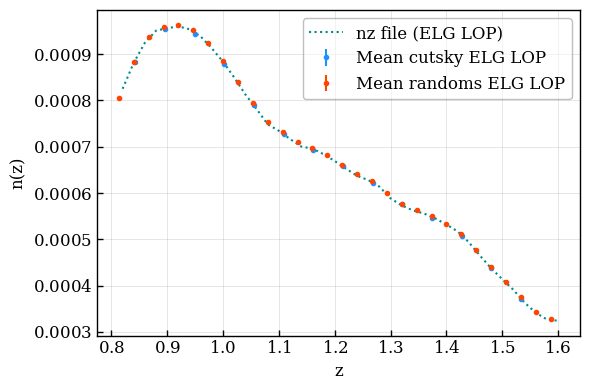

In [160]:
#plt.plot(density_cutsky_ELG.z[density_cutsky_ELG.z>0.8], density_cutsky_ELG.nbar[density_cutsky_ELG.z>0.8], label="Cutsky ELG", color='C0')
#plt.plot(density_cutsky_ELG_LOP.z[density_cutsky_ELG_LOP.z>0.8], density_cutsky_ELG_LOP.nbar[density_cutsky_ELG_LOP.z>0.8], label="Cutsky ELG LOP", color="C0", ls=':')
#plt.plot(z_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], mean_density_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], label="Mean cutsky ELG LOP", color="C0", ls=':')
plt.errorbar(z_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], mean_density_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], std_density_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], color="C0", marker='.', ls='', label="Mean cutsky ELG LOP")
plt.errorbar(z_randoms_cutsky_ELG_LOP[z_randoms_cutsky_ELG_LOP>0.8], 0.99 * mean_density_randoms_cutsky_ELG_LOP[z_randoms_cutsky_ELG_LOP>0.8], std_density_randoms_cutsky_ELG_LOP[z_randoms_cutsky_ELG_LOP>0.8], color="C1", marker='.', ls='', label="Mean randoms ELG LOP")
#plt.plot(density_ELG_LOP.z, density_ELG_LOP.nbar, label="Processed ELG LOP")
rescaling = 0.89 #0.7345658717688022
#plt.plot(zELG[zELG>0.8], nbarELG[zELG>0.8] * rescaling, label="nz file (ELG)", color='C1')
plt.plot(zELG[zELG>0.8], w1[zELG>0.8] * nbarELG[zELG>0.8] * rescaling, label="nz file (ELG LOP)", color='C2', ls=':')
#plt.plot(zELG[zELG>0.8], w2[zELG>0.8], label="w2", color='C3', ls='--')
#plt.plot(zELG_LOP[zELG_LOP>0.8], nbarELG_LOP[zELG_LOP>0.8], label="nz file (ELG_LOP)")
#plt.plot(density_randoms_cutsky_ELG_LOP.z, 0.99 * density_randoms_cutsky_ELG_LOP.nbar, label='randoms')
plt.xlabel('z')
plt.ylabel('n(z)')
plt.legend()
plt.savefig(os.path.join(plots_dir, "comparison_nz_ELG_cutsky"))
plt.show()

In [163]:
z = zELG[zELG>0.8]
mean_data_interp = interp1d(z_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], mean_density_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], bounds_error=False)(z)
std_data_interp = interp1d(z_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], std_density_cutsky_ELG_LOP[z_cutsky_ELG_LOP>0.8], bounds_error=False)(z)
mean_randoms_interp = interp1d(z_randoms_cutsky_ELG_LOP[z_randoms_cutsky_ELG_LOP>0.8], mean_density_randoms_cutsky_ELG_LOP[z_randoms_cutsky_ELG_LOP>0.8], bounds_error=False)(z)
std_randoms_interp = interp1d(z_randoms_cutsky_ELG_LOP[z_randoms_cutsky_ELG_LOP>0.8], std_density_randoms_cutsky_ELG_LOP[z_randoms_cutsky_ELG_LOP>0.8], bounds_error=False)(z)

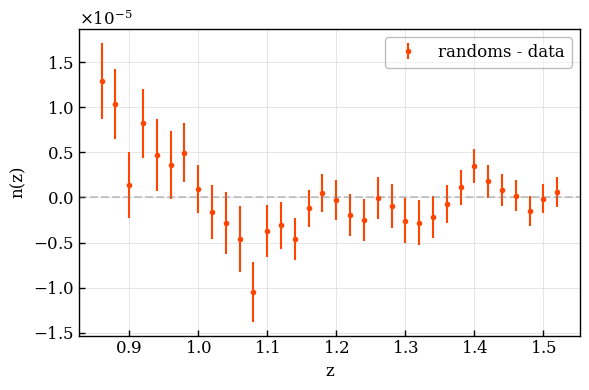

In [189]:
rescaling = 0.89 #0.7345658717688022
#plt.errorbar(z, mean_data_interp - w1[zELG>0.8] * nbarELG[zELG>0.8] * rescaling, std_data_interp, color="C0", marker='.', ls='', label="Data - n(z) file")
#plt.errorbar(z, 0.988*mean_randoms_interp - w1[zELG>0.8] * nbarELG[zELG>0.8] * rescaling, std_randoms_interp, color="C1", marker='.', ls='', label="Randoms - n(z) file")
plt.errorbar(z, 0.985*mean_randoms_interp - mean_data_interp, std_data_interp, color="C1", marker='.', ls='', label="randoms - data")
plt.xlabel('z')
plt.ylabel('n(z)')
plt.legend()
plt.axhline(0, color='grey', alpha=0.4, ls='--')
plt.savefig(os.path.join(plots_dir, "comparison_nz_ELG_cutsky_data_randoms"))
plt.show()

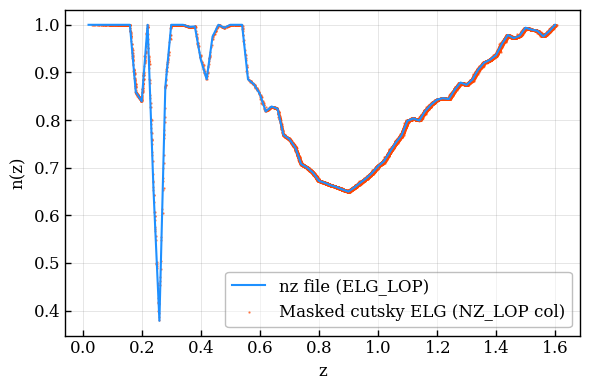

In [42]:
plt.plot(zELG_LOP, nbarELG_LOP, label="nz file (ELG_LOP)")
#plt.scatter(data_raw_cutsky_ELG['Z'][::1000], data_raw_cutsky_ELG['NZ'][::1000], label="Raw cutsky ELG (NZ col)", s=0.1)
plt.scatter(data_cutsky_ELG['Z'][::1000], data_cutsky_ELG['NZ_LOP'][::1000], label="Masked cutsky ELG (NZ_LOP col)", s=0.5, color="C1", alpha=0.6)
plt.xlabel('z')
plt.ylabel('n(z)')
plt.legend()
plt.savefig(os.path.join(plots_dir, "comparison_nz_ELG_LOP_cutsky"))
plt.show()

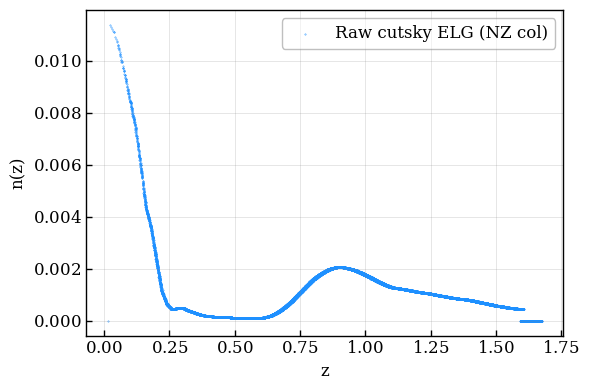

In [38]:
#plt.plot(zELG_LOP, nbarELG_LOP, label="nz file (ELG_LOP)")
plt.scatter(data_raw_cutsky_ELG['Z'][::1000], data_raw_cutsky_ELG['NZ'][::1000], label="Raw cutsky ELG (NZ col)", s=0.1)
#plt.scatter(data_raw_cutsky_ELG['Z'][::1000], data_raw_cutsky_ELG['NZ_LOP'][::1000], label="Raw cutsky ELG (NZ_LOP col)", s=0.1, color="C1", alpha=0.6)
plt.xlabel('z')
plt.ylabel('n(z)')
plt.legend()
plt.savefig(os.path.join(plots_dir, "nz_ELG_cutsky"))
plt.show()